In [24]:
import gymnasium as gym
import numpy as np
import pandas as pd
from gymnasium import spaces
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import SubprocVecEnv
import torch
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

class FartcoinTradingEnv(gym.Env):
    def __init__(self, data_path):
        super(FartcoinTradingEnv, self).__init__()
        
        # Load and preprocess data
        self.df = pd.read_csv(data_path)
        self.df['date'] = pd.to_datetime(self.df['date'])
        self.df = self.df.sort_values(by='date').reset_index(drop=True)
        
        # Environment state variables
        self.current_step = 0
        self.usdc_balance = 1000  # Starting with 1000 USDC
        self.fartcoin_balance = 0
        self.initial_balance = 1000
        self.highest_price_since_buy = None  # For trailing stop-loss
        
        # Define action space: {0: Hold, 1: Buy 25%, 2: Buy 50%, 3: Buy 100%, 4: Sell 25%, 5: Sell 50%, 6: Sell 100%, 7: Stop-Loss Sell}
        self.action_space = spaces.Discrete(8)
        
        # Define observation space (normalized price data + balances)
        self.observation_space = spaces.Box(
            low=0, high=1, shape=(5,), dtype=np.float32
        )

    def reset(self, seed=None, options=None):
        self.current_step = 0
        self.usdc_balance = 1000
        self.fartcoin_balance = 0
        self.highest_price_since_buy = None
        return self._next_observation(), {}
    
    def _next_observation(self):
        price = self.df.iloc[self.current_step]['price']
        rsi = self.df.iloc[self.current_step]['RSI_14_2h'] / 100
        sma = self.df.iloc[self.current_step]['SMA_20_2h'] / price
        upper_band = self.df.iloc[self.current_step]['Bollinger_Upper_2h'] / price
        lower_band = self.df.iloc[self.current_step]['Bollinger_Lower_2h'] / price
        
        return np.array([rsi, sma, upper_band, lower_band, price / 100], dtype=np.float32)
    
    def step(self, action):
        price = self.df.iloc[self.current_step]['price']
        reward = 0
        done = False

        buy_percentages = {1: 0.25, 2: 0.50, 3: 1.0}
        sell_percentages = {4: 0.25, 5: 0.50, 6: 1.0}

        # --- Buying Logic ---
        if action in buy_percentages and self.usdc_balance > 0:
            buy_amount = self.usdc_balance * buy_percentages[action]
            self.fartcoin_balance += buy_amount / price
            self.usdc_balance -= buy_amount
            self.highest_price_since_buy = price
            reward += 0.01  # Small reward for buying

        # Track highest price since last buy for stop-loss
        if self.fartcoin_balance > 0:
            self.highest_price_since_buy = max(self.highest_price_since_buy, price)

        # --- Stop-Loss Logic (Now triggers earlier) ---
        if action == 7 and self.fartcoin_balance > 0:
            if price <= self.highest_price_since_buy * 0.92:  # Adjusted stop-loss trigger
                self.usdc_balance += self.fartcoin_balance * price
                self.fartcoin_balance = 0
                self.highest_price_since_buy = None
                reward += 0.1  # Reward for executing stop-loss

        # --- Selling Logic ---
        if action in sell_percentages and self.fartcoin_balance > 0:
            sell_amount = self.fartcoin_balance * sell_percentages[action]
            self.usdc_balance += sell_amount * price
            self.fartcoin_balance -= sell_amount
            reward += 0.02  # Reward for selling

        # --- Reward Adjustments ---
        lower_band = self.df.iloc[self.current_step]['Bollinger_Lower_2h']
        upper_band = self.df.iloc[self.current_step]['Bollinger_Upper_2h']

        # Encourage buying near lower Bollinger Band
        if action in buy_percentages and price <= lower_band:
            reward += 0.05

        # Encourage selling near upper Bollinger Band
        if action in sell_percentages and price >= upper_band:
            reward += 0.1  # Increased reward for good exits

        # --- Penalize Holding During Downtrends ---
        if self.fartcoin_balance > 0 and price < self.highest_price_since_buy * 0.95:
            reward -= 0.1  # Penalize holding while price drops

        # Calculate portfolio value
        portfolio_value = self.usdc_balance + (self.fartcoin_balance * price)

        # Step forward in time
        self.current_step += 1
        if self.current_step >= len(self.df) - 1:
            done = True

        return self._next_observation(), reward, done, False, {}

    def render(self):
        print(f'Step: {self.current_step}, USDC: {self.usdc_balance}, Fartcoin: {self.fartcoin_balance}')

import torch
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import SubprocVecEnv

# Enable CuDNN benchmark optimization
torch.backends.cudnn.benchmark = True

if __name__ == "__main__":
    def train_dqn(env_path, timesteps=500000):
        num_envs = 32  # Adjust based on GPU capacity
        train_env = SubprocVecEnv([lambda: FartcoinTradingEnv(env_path) for _ in range(num_envs)])

        # Ensure CUDA is available and use GPU
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")

        # Adjust batch size dynamically based on VRAM
        batch_size = 8192  # Adjust as needed
        if torch.cuda.is_available():
            gpu_memory = torch.cuda.get_device_properties(device).total_memory
            if gpu_memory >= 12 * 1024**3:  # If 12GB+ VRAM (like your RTX 3060)
                batch_size = 16384  # Try even larger batch size for better GPU utilization

        # Initialize the model with mixed precision (FP16) if using CUDA
        model = DQN(
            "MlpPolicy", train_env, verbose=1, gamma=0.95, learning_rate=0.002,
            buffer_size=200000, batch_size=batch_size, train_freq=8, target_update_interval=1000,
            device=device
        )

        print(f"🚀 Training DQN Model on {device} with batch size {batch_size}...")

        # Corrected GradScaler Initialization
        scaler = torch.amp.GradScaler("cuda") if torch.cuda.is_available() else None

        # Use Mixed Precision Training
        with torch.amp.autocast("cuda"):
            model.learn(total_timesteps=timesteps, progress_bar=True, log_interval=1000)

        model.save(r"C:\Users\Chris\Documents\fartcoin_dqn_trader")

        print("✅ Model training complete!")

    train_dqn(r"C:\Users\Chris\Documents\fartcoin_to_2025_02_25 first 90 with peaks and stoploss and dips.csv")


Output()

✅ Model training complete!


Running backtest...
Trade log updated with Fartcoin value in USDC.
Trade Log Summary:
Total Trades: 154
Total Buys: 0
Total Sells: 0
Total Stop-Loss Sells: 154
Final USDC Balance: 0.00
Final Fartcoin Holdings: 1699.739787
Final Portfolio Value: 512.40
Last 10 Trades:
               date    price  action  usdc_balance  fartcoin_holdings  portfolio_value
2025-02-25 02:00:00 0.276140       3           0.0        1699.739787       469.365639
2025-02-25 04:00:00 0.277109       3           0.0        1699.739787       471.013381
2025-02-25 06:00:00 0.271341       3           0.0        1699.739787       461.208830
2025-02-25 08:00:00 0.269626       3           0.0        1699.739787       458.293672
2025-02-25 10:00:00 0.286826       3           0.0        1699.739787       487.530292
2025-02-25 12:00:00 0.275771       3           0.0        1699.739787       468.738843
2025-02-25 14:00:00 0.289382       3           0.0        1699.739787       491.873874
2025-02-25 16:00:00 0.289510       3

C:\Users\Chris\AppData\Local\Temp\ipykernel_26040\3549430939.py:103: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


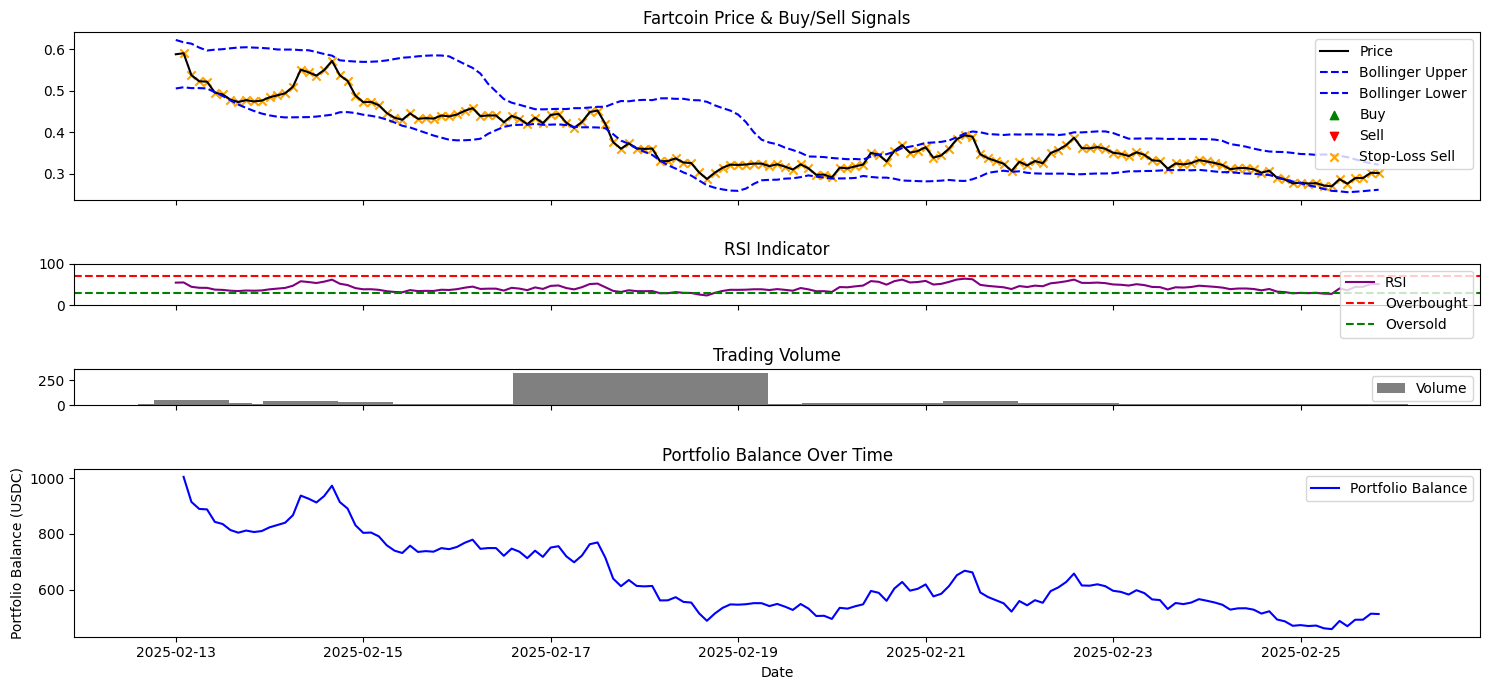

In [25]:


def backtest_dqn(model_path, test_data_path):
    print("Running backtest...")
    
    # Create the test environment and load the trained model
    test_env = FartcoinTradingEnv(test_data_path)
    model = DQN.load(model_path)
    
    # Reset the environment (assumes reset() returns (obs, info))
    obs, _ = test_env.reset()
    done = False
    trades = []
    balance_history = []
    date_history = []
    
    while not done:
        # Predict an action; ensure deterministic output and convert to int
        action, _ = model.predict(obs, deterministic=True)
        action = int(action)
        
        # Use the updated Gym API unpacking: ignore the truncated value
        obs, reward, done, _, info = test_env.step(action)
    
        # Ensure the current step is within the data frame's index bounds
        current_step = min(test_env.current_step, len(test_env.df) - 1)
        current_price = test_env.df.loc[current_step, "price"]
        date = test_env.df.loc[current_step, "date"]
        usdc_balance = test_env.usdc_balance
        fartcoin_holdings = test_env.fartcoin_balance
        portfolio_value = usdc_balance + (fartcoin_holdings * current_price)
        
        balance_history.append(portfolio_value)
        date_history.append(date)
        trades.append((date, current_price, action, usdc_balance, fartcoin_holdings, portfolio_value))
    
    trades_df = pd.DataFrame(trades, columns=["date", "price", "action", "usdc_balance", "fartcoin_holdings", "portfolio_value"])
    
    # Print Trade Summary
    print("Trade log updated with Fartcoin value in USDC.")
    print("Trade Log Summary:")
    print(f"Total Trades: {len(trades_df)}")
    print(f"Total Buys: {len(trades_df[trades_df['action'] == 1])}")
    print(f"Total Sells: {len(trades_df[trades_df['action'] == 2])}")
    print(f"Total Stop-Loss Sells: {len(trades_df[trades_df['action'] == 3])}")
    if not trades_df.empty:
        print(f"Final USDC Balance: {trades_df.iloc[-1]['usdc_balance']:.2f}")
        print(f"Final Fartcoin Holdings: {trades_df.iloc[-1]['fartcoin_holdings']:.6f}")
        print(f"Final Portfolio Value: {trades_df.iloc[-1]['portfolio_value']:.2f}")
    else:
        print("No trades executed.")
    
    if len(trades_df) > 0:
        print("Last 10 Trades:")
        print(trades_df.tail(10).to_string(index=False))
    
    # Plotting the results
    fig, axes = plt.subplots(4, 1, figsize=(15, 7), sharex=True, 
                             gridspec_kw={'height_ratios': [3, 0.75, 0.65, 3]})
    
    # --- Price Chart with Buy/Sell Signals ---
    ax1 = axes[0]
    ax1.plot(test_env.df["date"], test_env.df["price"], label="Price", color="black")
    ax1.plot(test_env.df["date"], test_env.df["Bollinger_Upper_2h"], linestyle="dashed", color="blue", label="Bollinger Upper")
    ax1.plot(test_env.df["date"], test_env.df["Bollinger_Lower_2h"], linestyle="dashed", color="blue", label="Bollinger Lower")
    
    buy_trades = trades_df[trades_df["action"] == 1]
    sell_trades = trades_df[trades_df["action"] == 2]
    stoploss_trades = trades_df[trades_df["action"] == 3]
    
    ax1.scatter(buy_trades["date"], buy_trades["price"], color="green", marker="^", label="Buy")
    ax1.scatter(sell_trades["date"], sell_trades["price"], color="red", marker="v", label="Sell")
    ax1.scatter(stoploss_trades["date"], stoploss_trades["price"], color="orange", marker="x", label="Stop-Loss Sell")
    ax1.set_title("Fartcoin Price & Buy/Sell Signals")
    ax1.legend()
    
    # --- RSI Indicator ---
    ax2 = axes[1]
    ax2.plot(test_env.df["date"], test_env.df["RSI_14_2h"], color="purple", label="RSI")
    ax2.axhline(70, linestyle="dashed", color="red", label="Overbought")
    ax2.axhline(30, linestyle="dashed", color="green", label="Oversold")
    ax2.set_ylim(0, 100)
    ax2.set_title("RSI Indicator")
    ax2.legend()
    
    # --- Trading Volume ---
    ax3 = axes[2]
    ax3.bar(test_env.df["date"], test_env.df["volume_estimated"], color="gray", label="Volume")
    ax3.set_ylim(0, max(test_env.df["volume_estimated"]) * 1.1)
    ax3.set_title("Trading Volume")
    ax3.legend()
    
    # --- Portfolio Value Over Time ---
    ax4 = axes[3]
    ax4.plot(date_history, balance_history, label="Portfolio Balance", color="blue")
    ax4.set_xlabel("Date")
    ax4.set_ylabel("Portfolio Balance (USDC)")
    ax4.set_title("Portfolio Balance Over Time")
    ax4.legend()
    
    # Format the x-axis dates
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    ax1.tick_params(axis="x", rotation=45)
    
    plt.tight_layout()
    plt.show()

# Example Usage
if __name__ == "__main__":
    backtest_dqn(
        r"C:\Users\Chris\Documents\fartcoin_dqn_trader",
        r"C:\Users\Chris\Documents\fartcoin_to_2025_02_25 last 10 with peaks and stoploss and dips.csv"
    )
